## 1. Import and Install

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

     -------------------------------------- 455.9/455.9 MB 3.6 MB/s eta 0:00:00
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
     ---------------------------------------- 49.0/49.0 MB 5.5 MB/s eta 0:00:00
     -------------------------------------- 444.1/444.1 MB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 42.5/42.5 MB 8.1 MB/s eta 0:00:00


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
                             ) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                             )  
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2)
                             ) 
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                             ) 
    

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

## 3. Extract Keypoint Values

In [8]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [9]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)


In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [11]:
result_test = extract_keypoints(results)

In [12]:
np.save('0', result_test)

In [13]:
np.load('0.npy')

array([ 0.59613025,  0.49138561, -1.57097471, ...,  0.        ,
        0.        ,  0.        ])

## 4. Setup Folders for Collection

In [7]:
# path for exported data, numpy arrays, store in firestore
DATA_PATH = os.path.join('MP_Data')

#Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'nothing', 'a', 'two'])

# 30 Videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [8]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

 ## 5. Collect Keypoint Values for Training and Testing

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
                for frame_num in range(sequence_length):
                    
                    # Read feed
                    ret, frame = cap.read()
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)
                    
                    # New Apply wait logic
                    if frame_num == 0:
                        cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.waitKey(1000)
                    else:
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
    cap.release()
    cv2.destroyAllWindows()

## 6. Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2, 'nothing': 3, 'a': 4, 'two': 5}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
np.array(sequences).shape

(180, 30, 1662)

In [15]:
np.array(labels).shape

(180,)

In [16]:
X = np.array(sequences)
X

array([[[ 6.20321989e-01,  6.67390764e-01, -9.95931804e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.20327353e-01,  6.67589188e-01, -1.22147453e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.20199502e-01,  6.69138134e-01, -1.12897134e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 6.25986516e-01,  6.62343204e-01, -1.57499945e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.24870479e-01,  6.64018333e-01, -1.57079625e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.23582661e-01,  6.68515265e-01, -1.60161805e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 6.22465074e-01,  6.69464111e-01, -1.68474793e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.31627083e-01,  6.59975827e-01, -1.68089700e+00, ...,
          0.00000000e+00,  0.00000000e

In [17]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [18]:
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [19]:
y_train.shape

(171, 6)

## 7. Build and Train LSTM Neural Network


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [21]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir= log_dir)

In [22]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
model.fit(x_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
6/6 [==============================] - 10s 502ms/step - loss: 21.0013 - categorical_accuracy: 0.1637
Epoch 2/1000
6/6 [==============================] - 3s 489ms/step - loss: 19.2978 - categorical_accuracy: 0.1637
Epoch 3/1000
6/6 [==============================] - 3s 479ms/step - loss: 7.5429 - categorical_accuracy: 0.0819
Epoch 4/1000
6/6 [==============================] - 3s 475ms/step - loss: 17.8682 - categorical_accuracy: 0.1871
Epoch 5/1000
6/6 [==============================] - 3s 483ms/step - loss: 8.2027 - categorical_accuracy: 0.1696
Epoch 6/1000
6/6 [==============================] - 3s 499ms/step - loss: 4.5270 - categorical_accuracy: 0.1520
Epoch 7/1000
6/6 [==============================] - 3s 467ms/step - loss: 2.4759 - categorical_accuracy: 0.1871
Epoch 8/1000
6/6 [==============================] - 3s 476ms/step - loss: 1.8106 - categorical_accuracy: 0.2632
Epoch 9/1000
6/6 [==============================] - 3s 470ms/step - loss: 1.8290 - categorical_accur

6/6 [==============================] - 3s 499ms/step - loss: 0.8186 - categorical_accuracy: 0.6199
Epoch 74/1000
6/6 [==============================] - 3s 507ms/step - loss: 0.7581 - categorical_accuracy: 0.6842
Epoch 75/1000
6/6 [==============================] - 3s 504ms/step - loss: 0.6403 - categorical_accuracy: 0.7018
Epoch 76/1000
6/6 [==============================] - 3s 499ms/step - loss: 0.5860 - categorical_accuracy: 0.8012
Epoch 77/1000
6/6 [==============================] - 3s 491ms/step - loss: 0.6075 - categorical_accuracy: 0.7485
Epoch 78/1000
6/6 [==============================] - 3s 499ms/step - loss: 0.8286 - categorical_accuracy: 0.6491
Epoch 79/1000
6/6 [==============================] - 3s 484ms/step - loss: 0.6472 - categorical_accuracy: 0.7251
Epoch 80/1000
6/6 [==============================] - 3s 487ms/step - loss: 0.4845 - categorical_accuracy: 0.7778
Epoch 81/1000
6/6 [==============================] - 3s 473ms/step - loss: 0.5123 - categorical_accuracy: 0.77

6/6 [==============================] - 3s 492ms/step - loss: 0.9707 - categorical_accuracy: 0.7018
Epoch 146/1000
6/6 [==============================] - 3s 483ms/step - loss: 0.7170 - categorical_accuracy: 0.8187
Epoch 147/1000
6/6 [==============================] - 3s 534ms/step - loss: 0.6409 - categorical_accuracy: 0.7661
Epoch 148/1000
6/6 [==============================] - 3s 485ms/step - loss: 0.4530 - categorical_accuracy: 0.7895
Epoch 149/1000
6/6 [==============================] - 3s 584ms/step - loss: 0.3551 - categorical_accuracy: 0.8246
Epoch 150/1000
6/6 [==============================] - 4s 646ms/step - loss: 0.3358 - categorical_accuracy: 0.8304
Epoch 151/1000
6/6 [==============================] - 3s 500ms/step - loss: 0.3222 - categorical_accuracy: 0.8246
Epoch 152/1000
6/6 [==============================] - 3s 481ms/step - loss: 0.2910 - categorical_accuracy: 0.8538
Epoch 153/1000
6/6 [==============================] - 3s 484ms/step - loss: 0.3341 - categorical_accura

Epoch 217/1000
6/6 [==============================] - 3s 484ms/step - loss: 0.2689 - categorical_accuracy: 0.8538
Epoch 218/1000
6/6 [==============================] - 3s 517ms/step - loss: 0.2577 - categorical_accuracy: 0.8596
Epoch 219/1000
6/6 [==============================] - 3s 491ms/step - loss: 0.1982 - categorical_accuracy: 0.9006
Epoch 220/1000
6/6 [==============================] - 3s 482ms/step - loss: 0.1940 - categorical_accuracy: 0.9298
Epoch 221/1000
6/6 [==============================] - 3s 527ms/step - loss: 0.1981 - categorical_accuracy: 0.9357
Epoch 222/1000
6/6 [==============================] - 3s 545ms/step - loss: 0.2075 - categorical_accuracy: 0.9298
Epoch 223/1000
6/6 [==============================] - 3s 489ms/step - loss: 0.2185 - categorical_accuracy: 0.9006
Epoch 224/1000
6/6 [==============================] - 3s 515ms/step - loss: 0.1743 - categorical_accuracy: 0.9240
Epoch 225/1000
6/6 [==============================] - 3s 543ms/step - loss: 0.2010 - cat

KeyboardInterrupt: 

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 596,774
Trainable params: 596,774
Non-trai

## 8. Make Predictions

In [26]:
res = model.predict(X_test)

1/1 [==============================] - 0s 497ms/step


In [27]:
actions[np.argmax(res[0])]

'thanks'

In [28]:
actions[np.argmax(y_test[0])]

'thanks'

In [29]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", score[1])

Test accuracy: 1.0


## 9. Save Weights

In [35]:
model.save('action.h5')

In [129]:
del model

In [23]:
model.load_weights('action.h5')

## 10. Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [31]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 79ms/step


In [32]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [33]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[8, 0],
        [0, 1]],

       [[7, 0],
        [0, 2]],

       [[8, 0],
        [0, 1]],

       [[7, 0],
        [0, 2]],

       [[8, 0],
        [0, 1]],

       [[7, 0],
        [0, 2]]], dtype=int64)

In [34]:
accuracy_score(ytrue, yhat)

1.0

## 11. Test in Real Time

In [138]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

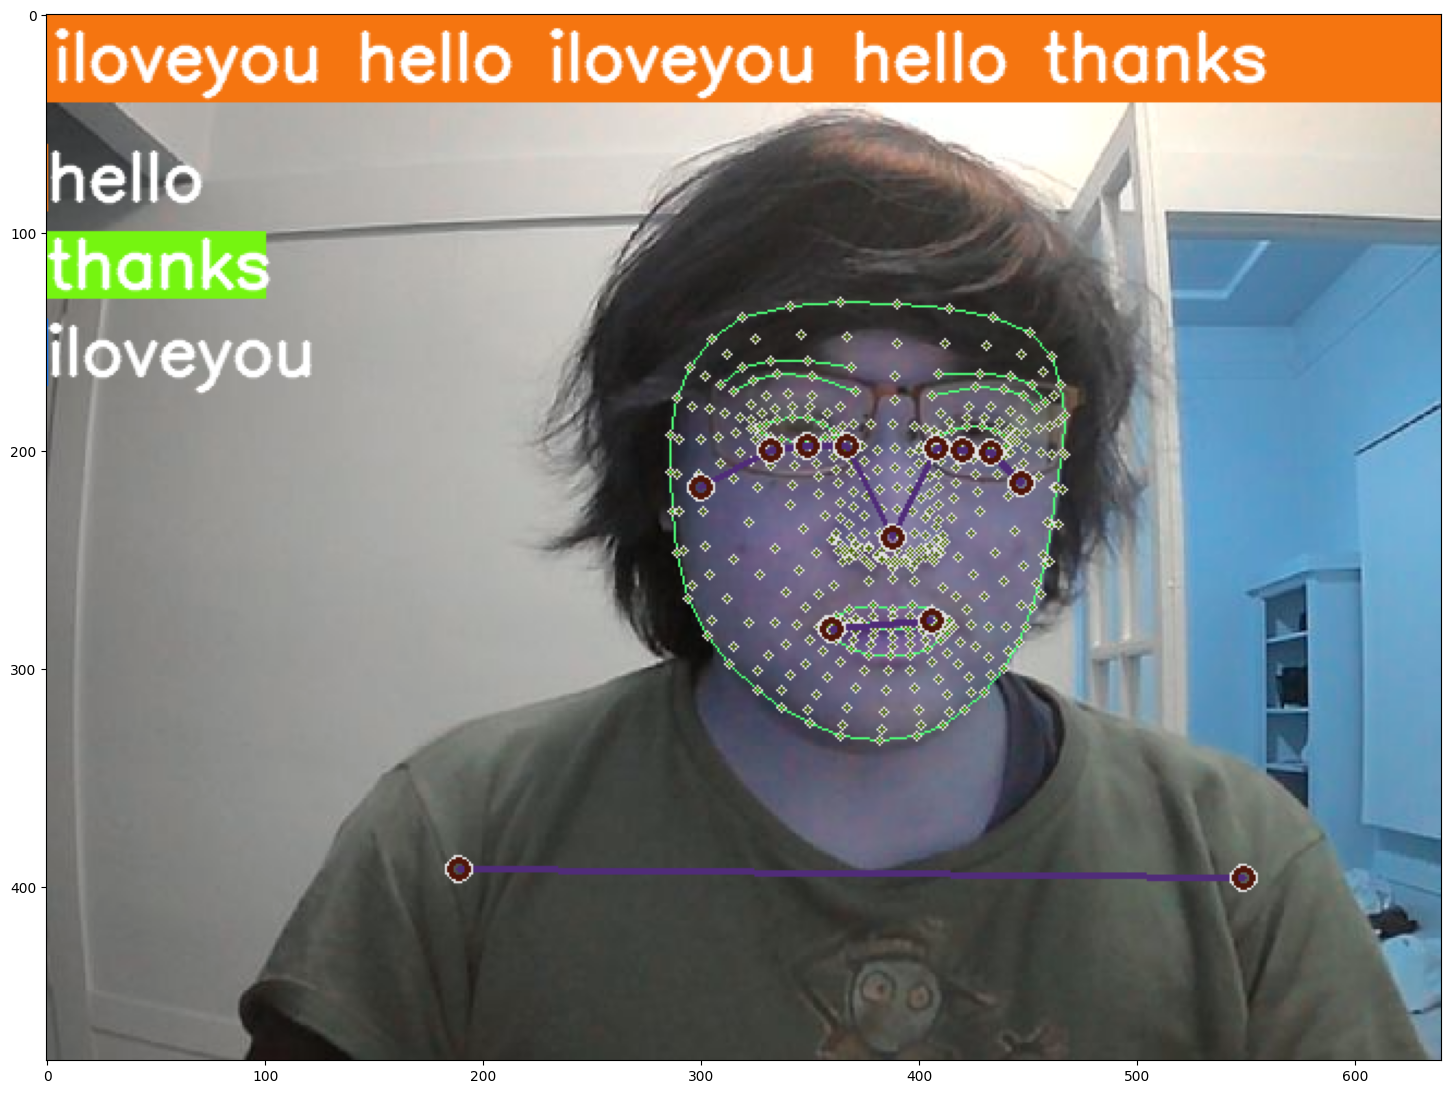

In [140]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [36]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 61ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 75ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 64ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 70ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 68ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 67ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 63ms/step
two
<class 'mediapipe.python.solution_base.Solutio

1/1 [==============================] - 0s 70ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 69ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 68ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 59ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
a
<class 'mediapipe.python.solution_base.SolutionOutputs'>

1/1 [==============================] - 0s 65ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 64ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 65ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 70ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 67ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 58ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 69ms/step
two
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 64ms/step
two
<class 'mediapipe.python.solution_base.S